# Access locations and times of Veery encounters

For this challenge, you will use a database called the [Global
Biodiversity Information Facility (GBIF)](https://www.gbif.org/). GBIF
is compiled from species observation data all over the world, and
includes everything from museum specimens to photos taken by citizen
scientists in their backyards.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Explore GBIF</div></div><div class="callout-body-container callout-body"><p>Before your get started, go to the <a
href="https://www.gbif.org/occurrence/search">GBIF occurrences search
page</a> and explore the data.</p></div></div>

> **Contribute to open data**
>
> You can get your own observations added to GBIF using
> [iNaturalist](https://www.inaturalist.org/)!

### Set up your code to prepare for download

We will be getting data from a source called [GBIF (Global Biodiversity
Information Facility)](https://www.gbif.org/). We need a package called
`pygbif` to access the data, which may not be included in your
environment. Install it by running the cell below:

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Import packages</div></div><div class="callout-body-container callout-body"><p>In the imports cell, we’ve included some packages that you will need.
Add imports for packages that will help you:</p>
<ol type="1">
<li>Work with reproducible file paths</li>
<li>Work with tabular data</li>
</ol></div></div>

In [1]:
import time
import zipfile
from getpass import getpass
from glob import glob

import os
import pathlib

from getpass import getpass
from glob import glob

import geopandas as gpd
import pandas as pd

import pygbif.occurrences as occ
import pygbif.species as species

# get month names
import calendar

# libraries for Dynamic mapping
import geoviews as gv
import hvplot.pandas
import cartopy
import cartopy.crs as ccrs
import panel as pn
pn.extension()



/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [9]:
# Create data directory in the home folder
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'species',
)
os.makedirs(data_dir, exist_ok=True)

# Define the directory name for GBIF data
gbif_dir = os.path.join(data_dir, 'gbif_siberian')
gbif_dir

'/home/jovyan/earth-analytics/data/species/gbif_siberian'

:::

### Register and log in to GBIF

You will need a [GBIF account](https://www.gbif.org/) to complete this
challenge. You can use your GitHub account to authenticate with GBIF.
Then, run the following code to save your credentials on your computer.

> **Warning**
>
> Your email address **must** match the email you used to sign up for
> GBIF!

> **Tip**
>
> If you accidentally enter your credentials wrong, you can set
> `reset_credentials=True` instead of `reset_credentials=False`.

In [3]:
reset_credentials = False
# GBIF needs a username, password, and email
credentials = dict(
    GBIF_USER=(input, 'username'),
    GBIF_PWD=(getpass, 'password'),
    GBIF_EMAIL=(input, 'email'),
)
for env_variable, (prompt_func, prompt_text) in credentials.items():
    # Delete credential from environment if requested
    if reset_credentials and (env_variable in os.environ):
        os.environ.pop(env_variable)
    # Ask for credential and save to environment
    if not env_variable in os.environ:
        os.environ[env_variable] = prompt_func(prompt_text)

### Get the species key

> ** Your task**
>
> 1.  Replace the `species_name` with the name of the species you want
>     to look up
> 2.  Run the code to get the species key

In [4]:
# Query species
species_info = species.name_lookup('grus leucogeranus', rank='SPECIES')

# Get the first result
first_result = species_info['results'][0]

# Get the species key (nubKey)
species_key = first_result['nubKey']

# Check the result
first_result['species'], species_key

('Grus leucogeranus', 2474961)

In [9]:
species_key

2474953

### Download data from GBIF

::: {.callout-task title=“Submit a request to GBIF”

1.  Replace `csv_file_pattern` with a string that will match **any**
    `.csv` file when used in the `glob` function. HINT: the character
    `*` represents any number of any values except the file separator
    (e.g. `/`)

2.  Add parameters to the GBIF download function, `occ.download()` to
    limit your query to:

    -   observations
    -   from 2023
    -   with spatial coordinates.

3.  Then, run the download. **This can take a few minutes**. :::

    -   Can check progress at <https://www.gbif.org/user/download>.

In [6]:
"speciesKey =" + str(species_key)

'speciesKey =2474961'

In [10]:
# Only download once
gbif_pattern = os.path.join(gbif_dir, '*.csv')
if not glob(gbif_pattern):
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF
        gbif_query = occ.download([
            "speciesKey = " + str(species_key),
            "hasCoordinate = TRUE",
            "year = 2023",
        ])
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

    # Wait for the download to build
    download_key = os.environ['GBIF_DOWNLOAD_KEY']
    wait = occ.download_meta(download_key)['status']
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(download_key)['status']
        time.sleep(5)

    # Download GBIF data
    download_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'], 
        path=data_dir)

    # Unzip GBIF data
    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=gbif_dir)

# Find the extracted .csv file path (take the first result)
gbif_path = glob(gbif_pattern)[0]

INFO:Your download key is 0001022-241024112534372
INFO:Download file size: 20668 bytes
INFO:On disk at /home/jovyan/earth-analytics/data/species/0001022-241024112534372.zip


download key is 0020917-241007104925546
GBIF.org (17 October 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.4d3k48

In [11]:
gbif_path = glob(gbif_pattern)[0]
gbif_path

'/home/jovyan/earth-analytics/data/species/gbif_siberian/0001022-241024112534372.csv'

### Load the GBIF data into Python

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Load GBIF data</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Look at the beginning of the file you downloaded using the code
below. What do you think the <strong>delimiter</strong> is?</li>
<li>Run the following code cell. What happens?</li>
<li>Uncomment and modify the parameters of <code>pd.read_csv()</code>
below until your data loads successfully and you have only the columns
you want.</li>
</ol></div></div>

You can use the following code to look at the beginning of your file:

I copied from <https://github.com/lauren-alexandra/lauren-alexandra.github.io/blob/main/willow-flycatcher-distribution/willow-flycatcher-distribution.ipynb>
and Lauren Gleason

In [12]:
!head -n 2 $gbif_path 

gbifID	datasetKey	occurrenceID	kingdom	phylum	class	order	family	genus	species	infraspecificEpithet	taxonRank	scientificName	verbatimScientificName	verbatimScientificNameAuthorship	countryCode	locality	stateProvince	occurrenceStatus	individualCount	publishingOrgKey	decimalLatitude	decimalLongitude	coordinateUncertaintyInMeters	coordinatePrecision	elevation	elevationAccuracy	depth	depthAccuracy	eventDate	day	month	year	taxonKey	speciesKey	basisOfRecord	institutionCode	collectionCode	catalogNumber	recordNumber	identifiedBy	dateIdentified	license	rightsHolder	recordedBy	typeStatus	establishmentMeans	lastInterpreted	mediaType	issue
4926044636	50c9509d-22c7-4a22-a47d-8c48425ef4a7	https://www.inaturalist.org/observations/235678300	Animalia	Chordata	Aves	Gruiformes	Gruidae	Grus	Grus leucogeranus		SPECIES	Leucogeranus leucogeranus (Pallas, 1773)	Leucogeranus leucogeranus		CN		Hubei	PRESENT		28eb1a3f-1c15-4a95-931a-4af90ecb574d	30.3671	113.847664	29382.0						2023-12-25T09:18	25	12	2023	9531123

In [ ]:
# Load the GBIF data
gbif_df = pd.read_csv(
    gbif_path, 
    delimiter='\t',
    index_col='gbifID',
    on_bad_lines='skip',
    usecols=['gbifID', 'month', 'year', 'countryCode', 'stateProvince', 'decimalLatitude', 'decimalLongitude']
)
gbif_df.head()

,countryCode,stateProvince,decimalLatitude,decimalLongitude,month,year
gbifID,,,,,,
4926044636,CN,Hubei,30.367100,113.847664,12,2023
4921811074,CN,Hunan,29.515060,112.802922,1,2023
4912663694,JP,NaN,27.049600,127.976100,2,2023
4910940060,CN,Jiangxi,28.928361,116.360070,4,2023
4889696053,MN,Hentiy,48.440521,110.358567,6,2023


## Convert GBIF data to a GeoDataFrame by Month

In [17]:
gdf_monthly = (
    gpd.GeoDataFrame(
        gbif_df, 
        geometry=gpd.points_from_xy(
            gbif_df.decimalLongitude, 
            gbif_df.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['month', 'geometry']]
)

gdf_monthly

,month,geometry
gbifID,,
4926044636,12,POINT (113.84766 30.3671)
4921811074,1,POINT (112.80292 29.51506)
4912663694,2,POINT (127.9761 27.0496)
4910940060,4,POINT (116.36007 28.92836)
4889696053,6,POINT (110.35857 48.44052)
...,...,...
4039428305,2,POINT (117.03775 30.344)
4038148648,1,POINT (116.3279 28.89)
4038146636,1,POINT (116.3279 28.89)


### Download and save ecoregion boundaries

Ecoregions represent boundaries formed by biotic and abiotic conditions: geology, landforms, soils, vegetation, land use, wildlife, climate, and hydrology.

In [18]:
# Set up the ecoregion boundary URL
ecoregions_url = "https://storage.googleapis.com/teow2016/Ecoregions2017.zip"

# Set up a path to save the data on your machine
ecoregions_dir = os.path.join(data_dir, 'wwf_ecoregions')

# Make the ecoregions directory
os.makedirs(ecoregions_dir, exist_ok=True)

# Join ecoregions shapefile path
ecoregions_path = os.path.join(ecoregions_dir, 'wwf_ecoregions.shp')

# Only download once
if not os.path.exists(ecoregions_path):
    ecoregions_gdf = gpd.read_file(ecoregions_url)
    ecoregions_gdf.to_file(ecoregions_path)

In [18]:
%%bash
find ~/earth-analytics/data/species -name '*.shp'

/home/jovyan/earth-analytics/data/species/wwf_ecoregions/wwf_ecoregions.shp


In [20]:
# Open up the ecoregions boundaries
ecoregions_gdf = (
    gpd.read_file(ecoregions_path)
    .rename(columns={
        'ECO_NAME': 'name',
        'SHAPE_AREA': 'area'})
    [['name', 'area', 'geometry']]
)

# Name the index so it will match the other data later on
ecoregions_gdf.index.name = 'ecoregion'

In [21]:
ecoregions_gdf

,name,area,geometry
ecoregion,,,
0,Adelie Land tundra,0.038948,"MULTIPOLYGON (((158.7141 -69.60657, 158.71264 ..."
1,Admiralty Islands lowland rain forests,0.170599,"MULTIPOLYGON (((147.28819 -2.57589, 147.2715 -..."
2,Aegean and Western Turkey sclerophyllous and m...,13.844952,"MULTIPOLYGON (((26.88659 35.32161, 26.88297 35..."
3,Afghan Mountains semi-desert,1.355536,"MULTIPOLYGON (((65.48655 34.71401, 65.52872 34..."
4,Ahklun and Kilbuck Upland Tundra,8.196573,"MULTIPOLYGON (((-160.26404 58.64097, -160.2673..."
...,...,...,...
842,Sulawesi lowland rain forests,9.422097,"MULTIPOLYGON (((117.33111 -7.53306, 117.30525 ..."
843,East African montane forests,5.010930,"MULTIPOLYGON (((36.7375 -3.13, 36.7375 -3.1316..."
844,Eastern Arc forests,0.890325,"MULTIPOLYGON (((36.38 -8.96583, 36.38 -8.96667..."


In [21]:
%store ecoregions_gdf gdf_monthly

Stored 'ecoregions_gdf' (GeoDataFrame)
Stored 'gdf_monthly' (GeoDataFrame)


Identify the ecoregion for each observation

In [22]:
gbif_ecoregion_gdf = (
    ecoregions_gdf
    # Match the coordinate reference system of the GBIF data and the ecoregions
    # transform geometries to a new coordinate reference system
    .to_crs(gdf_monthly.crs)
    # Find ecoregion for each observation
    # spatial join
    .sjoin(
        gdf_monthly,
        how='inner', 
        predicate='contains')
    # Select the required columns
    [['month', 'name']]
)
gbif_ecoregion_gdf

,month,name
ecoregion,,
74,1,Bohai Sea saline meadow
74,11,Bohai Sea saline meadow
74,3,Bohai Sea saline meadow
74,1,Bohai Sea saline meadow
74,1,Bohai Sea saline meadow
...,...,...
713,1,Taiheiyo evergreen forests
713,12,Taiheiyo evergreen forests
775,7,West Siberian taiga


Count the observations in each ecoregion each month

In [24]:
def get_monthly_regional_observations(df, region_type, occurrence_name):

    occurrence_df = (
        df
        # For each region, for each month...
        .groupby([region_type, 'month'])
        # count the number of occurrences
        .agg(occurrences=(occurrence_name, 'count'))
    )

    # Get rid of rare observations (possible misidentification)
    occurrence_df = occurrence_df[occurrence_df["occurrences"] > 1]

    # Take the mean by region
    mean_occurrences_by_region = (
        occurrence_df
        .groupby([region_type])
        .mean()
    )

    # Take the mean by month
    mean_occurrences_by_month = (
        occurrence_df
        .groupby(['month'])
        .mean()
    )

    # Normalize by space and time for sampling effort
    # This accounts for the number of active observers in each location and time of year
    occurrence_df['norm_occurrences'] = (
        occurrence_df
        / mean_occurrences_by_region
        / mean_occurrences_by_month
    )

    return occurrence_df

In [25]:
occurrence_df = get_monthly_regional_observations(gbif_ecoregion_gdf, 'ecoregion', 'name')

occurrence_df

occurrences  norm_occurrences
ecoregion month                               
74        1                3          0.041667
107       1                7          0.048611
          2                5          0.049020
134       4                2          0.500000
154       1               78          0.084635
          2               40          0.061275
          4                2          0.026042
          11              14          0.040509
          12              58          0.048723
198       6                3          0.400000
          8                2          0.400000
321       4                2          0.500000
350       11               4          0.111111
677       12               4          0.032258
713       1                8          0.047619
          2                6          0.050420

<Axes: xlabel='month', ylabel='norm_occurrences'>

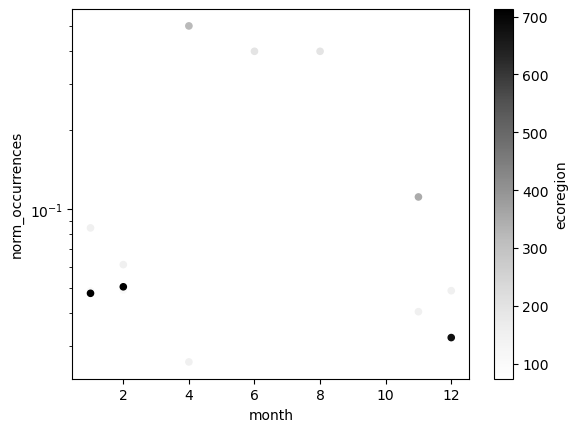

In [26]:
# plot to check distrubions 
occurrence_df.reset_index().plot.scatter(
    x='month', y='norm_occurrences', c='ecoregion',
    logy=True
)

Create a simplified GeoDataFrame for plot

In [27]:
"""
Streamlining plotting with hvplot by simplifying the geometry, projecting it to a Mercator projection that is compatible with
geoviews, and cropping off areas in the Arctic.
"""

# Speed up processing
ecoregions_gdf.geometry = ecoregions_gdf.simplify(
    .1, preserve_topology=False)

# Change the CRS to Mercator for mapping
ecoregions_gdf = ecoregions_gdf.to_crs(ccrs.Mercator())

ecoregions_gdf

,name,area,geometry
ecoregion,,,
0,Adelie Land tundra,0.038948,MULTIPOLYGON EMPTY
1,Admiralty Islands lowland rain forests,0.170599,"POLYGON ((16411777.375 -229101.376, 16384825.7..."
2,Aegean and Western Turkey sclerophyllous and m...,13.844952,"MULTIPOLYGON (((3391149.749 4336064.109, 33846..."
3,Afghan Mountains semi-desert,1.355536,"MULTIPOLYGON (((7369001.698 4093509.259, 73168..."
4,Ahklun and Kilbuck Upland Tundra,8.196573,"MULTIPOLYGON (((-17930832.005 8046779.358, -17..."
...,...,...,...
842,Sulawesi lowland rain forests,9.422097,"MULTIPOLYGON (((14113374.546 501721.962, 14128..."
843,East African montane forests,5.010930,"MULTIPOLYGON (((4298787.669 -137583.786, 42727..."
844,Eastern Arc forests,0.890325,"MULTIPOLYGON (((4267432.68 -493759.165, 428533..."


In [26]:
%store gbif_path
%who

Stored 'gbif_path' (str)
ac_CA	 ac_US	 calendar	 cartopy	 ccrs	 credentials	 data_dir	 ecoregions_dir	 ecoregions_gdf	 
ecoregions_path	 ecoregions_url	 env_variable	 first_result	 gbif_df	 gbif_dir	 gbif_ecoregion_gdf	 gbif_path	 gbif_pattern	 
gdf_monthly	 get_monthly_regional_observations	 getpass	 glob	 gpd	 gv	 hvplot	 occ	 occurrence_df	 
os	 pathlib	 pd	 pn	 prompt_func	 prompt_text	 reset_credentials	 species	 species_info	 
species_key	 time	 zipfile	 


Mapping monthly distribution

In [28]:
# Join the occurrences with the plotting GeoDataFrame
occurrence_gdf = ecoregions_gdf.join(occurrence_df[['norm_occurrences']])

# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = occurrence_gdf.total_bounds

# Define the slider widget
slider = pn.widgets.DiscreteSlider(
    name='month', 
    options={calendar.month_name[i]: i for i in range(1, 13)}
)

occurrence_gdf

name       area  \
ecoregion month                                                         
74        1                        Bohai Sea saline meadow   1.187602   
107       1                Caspian Hyrcanian mixed forests   5.604168   
          2                Caspian Hyrcanian mixed forests   5.604168   
134       4      Central China Loess Plateau mixed forests  37.104395   
154       1             Changjiang Plain evergreen forests  41.203493   
          2             Changjiang Plain evergreen forests  41.203493   
          4             Changjiang Plain evergreen forests  41.203493   
          11            Changjiang Plain evergreen forests  41.203493   
          12            Changjiang Plain evergreen forests  41.203493   
198       6                          Daurian forest steppe  26.252795   
          8                          Daurian forest steppe  26.252795   
321       4                   Huang He Plain mixed forests  43.295555   
350       11        Jian Nan subtropical evergreen forests  59.745023   
677       12              Southern Korea evergreen forests   1.449664   
713       1                     Taiheiyo evergreen forests  13.553387   
          2                     Taiheiyo evergreen forests  13.553387   

                                                          geometry  \
ecoregion month                                                      
74        1      MULTIPOLYGON (((13116898.113 4589071.254, 1319...   
107       1      MULTIPOLYGON (((5333143.547 4574764.516, 52538...   
          2      MULTIPOLYGON (((5333143.547 4574764.516, 52538...   
134       4      MULTIPOLYGON (((13378649.084 5076474.672, 1331...   
154       1      MULTIPOLYGON (((13613475.56 3473108.645, 13581...   
          2      MULTIPOLYGON (((13613475.56 3473108.645, 13581...   
          4      MULTIPOLYGON (((13613475.56 3473108.645, 13581...   
          11     MULTIPOLYGON (((13613475.56 3473108.645, 13581...   
          12     MULTIPOLYGON (((13613475.56 3473108.645, 13581...   
198       6      POLYGON ((13320358.199 6772264.491, 13349680.3...   
          8      POLYGON ((13320358.199 6772264.491, 13349680.3...   
321       4      POLYGON ((13332332.499 4862491.773, 13335344.1...   
350       11     MULTIPOLYGON (((13366375.518 3078256.552, 1334...   
677       12     MULTIPOLYGON (((14067544.103 4086271.62, 14056...   
713       1      MULTIPOLYGON (((14748057.024 4038696.166, 1473...   
          2      MULTIPOLYGON (((14748057.024 4038696.166, 1473...   

                 norm_occurrences  
ecoregion month                    
74        1              0.041667  
107       1              0.048611  
          2              0.049020  
134       4              0.500000  
154       1              0.084635  
          2              0.061275  
          4              0.026042  
          11             0.040509  
          12             0.048723  
198       6              0.400000  
          8              0.400000  
321       4              0.500000  
350       11             0.111111  
677       12             0.032258  
713       1              0.047619  
          2              0.050420

In [28]:
%store occurrence_gdf

Stored 'occurrence_gdf' (GeoDataFrame)


In [29]:
occurrence_gdf.hvplot(
    c='norm_occurrences',
    groupby='month',
    # Use background tiles
    title='Antigone canadensis Sandhill Crane Migration',
    #geo=True, 
    # crs=ccrs.Mercator(), 
    tiles='CartoLight',
    xlim=(xmin, xmax), ylim=(ymin, ymax),
    frame_height=600,
    frame_width=1400,
    colorbar=False,
    widgets={'month': slider},
    widget_location='bottom',
    width=500,
    height=500
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'48201618-3bfa-4a20-b7c3-62ec3778c85a': {'version…

In [30]:
# Plot occurrence by ecoregion and month
migration_plot = (
    occurrence_gdf
    .hvplot(
        c='norm_occurrences',
        groupby='month',
        # Use background tiles
        title = first_result['species'] + 'Siberian Crane Migration',
        #geo=True, 
        #crs=ccrs.Mercator(), 
        tiles='CartoLight',
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=600,
        frame_width=1400,
        colorbar=False,
        widgets={'month': slider},
        widget_location='bottom'
    )
)

# Save the plot
migration_plot.save('siberian-crane-migration.html', embed=True)

# Show the plot
migration_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'75b77849-fffd-4b5d-9717-7ed2b6b63d12': {'version…